## 1. Introduction

Air quality refers to the types and concentrations of pollutants in the air and the effects of meteorological conditions on human health and the environment. With the acceleration of urbanisation and industrialisation, air quality has become an issue of great concern. Poor air quality not only affects people's health and quality of life, but also has important impacts on ecosystems and climate. World Health Organization (2021) defines that any air pollution that leads to an increase in long-term mortality is harmful, that the burden of disease caused by air pollution is comparable to other major global health risks such as unhealthy diets and smoking, and that the greatest environmental threat to human health is air pollution.O3, PM2.5 and NO2 are the three major urban air pollutants that have the greatest impact on human health. Sicard et al. (2023) investigated global urban air pollution data over the past 20 years to estimate trends in the level of exposure of urban populations to air pollutants.Aguilar-Gomez et al. (2022) investigated the subclinical effects of air pollution and provided a more comprehensive analysis of the possible effects of air pollution on humans.

The dataset I have selected is called "World Air Quality Data 2024 (Updated)", which provides a comprehensive overview of air quality in different locations around the world, and I will be analysing Europe in detail. The dataset contains many pollutants: NO, NO2, NOX, SO2, PM2.5, CO, O3, PM10, PM1, BC

Firstly, after cleaning the data, I will show the distribution of the data, and based on the density and severity of pollution I will choose Europe for my study. Secondly, I will analyse and visualise the air pollution in each European country as a whole. Finally, the national pollution severity of each pollutant will be analysed in turn and corresponded to the map.

## 2. Data

### 2.1 Data Information

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import pyarrow.parquet as pq
!pip install contextily
import contextily as ctx
!pip install geopandas
import geopandas as gpd
from shapely.geometry import Point, Polygon

!pip install geoplot
import geoplot
import mapclassify as mc

from matplotlib.gridspec import GridSpec

import plotly.express as px

In [2]:
air = pd.read_csv('C:/Users/HW/Downloads/archive (1)/world_air_quality.csv',sep=';')

In [3]:
air.head(5)

Country Code City           Location            Coordinates Pollutant  \
0           JP  NaN  北九州市小倉北区大門一丁目６－４８  33.880833, 130.873056        NO   
1           JP  NaN   北九州市若松区本町三丁目１３－１      33.898056, 130.81       NO2   
2           JP  NaN   北九州市門司区大里原町１２－１２  33.895833, 130.935833       NOX   
3           JP  NaN          千歳市若草４－１３     42.786944, 141.605       NO2   
4           JP  NaN    千葉市稲毛区宮野木町９９６－９  35.653889, 140.097778       NOX   

      Source Name Unit  Value               Last Updated Country Label  
0  japan-soramame  ppm  0.002  2024-03-10T13:30:00+05:30         Japan  
1  japan-soramame  ppm  0.005  2024-03-10T13:30:00+05:30         Japan  
2  japan-soramame  ppm  0.013  2024-03-10T13:30:00+05:30         Japan  
3  japan-soramame  ppm  0.004  2024-03-10T13:30:00+05:30         Japan  
4  japan-soramame  ppm  0.003  2024-03-10T13:30:00+05:30         Japan

In [4]:
air.columns

Index(['Country Code', 'City', 'Location', 'Coordinates', 'Pollutant',
       'Source Name', 'Unit', 'Value', 'Last Updated', 'Country Label'],
      dtype='object')

In [5]:
air['Country Label'].unique()

array(['Japan', 'Kuwait', "Lao People's Dem. Rep.", 'Lithuania',
       'Luxembourg', 'Latvia', 'Montenegro',
       'Macedonia, The former Yugoslav Rep. of', 'Myanmar', 'Mongolia',
       'Mexico', 'Netherlands', 'Israel', 'India', 'Iraq', 'Iceland',
       'Italy', 'France', 'United Kingdom', 'Greece', 'Hong Kong, China',
       'Croatia', 'Hungary', 'Indonesia', 'Ireland', 'Spain', 'Finland',
       'Norway', 'Nepal', 'New Zealand', 'Peru', 'Poland',
       'West Bank and Gaza Strip', 'Portugal', 'Romania', 'Serbia',
       'Russian Federation', 'Saudi Arabia', 'Sweden', 'Slovenia',
       'Slovakia', 'Senegal', 'Thailand', 'Turkey', 'Trinidad and Tobago',
       'Taiwan, China', 'United States', nan, 'South Africa', 'Canada',
       'Switzerland', 'Chile', 'China', 'Colombia', 'Cyprus',
       'Czech Republic', 'Germany', 'United Arab Emirates', 'Armenia',
       'Austria', 'Australia', 'Belgium', 'Ecuador', 'Estonia',
       'Bulgaria', 'Brazil', 'Andorra', 'Bosnia and Herzegovina

### 2.2 Data Cleaning

After importing and viewing the data, let's perform data cleansing. Start by identifying which columns have missing values. We find that Country Label has 115 missing values, while Country Code has no missing values, so we can manually complete Country Label according to Country Code. then discard the remaining missing values and make sure there are no duplicates, and then filter out the values with contaminant level less than 0. There are some less common pollutant units in the data, but since the amount of data is very small, we remove them. To make it easier to construct the map, we split the coordinates into standard patterns and changed the type of latitude and longitude to float.

After cleaning the data, the individual data were visualised in maps with different projected coordinate systems based on latitude and longitude. After observing that air pollution is more severe in Europe, the dataset was filtered for each European country. The original geometric objects were then merged according to their spatial relationship with each other.

In [6]:
air.isna().sum()

Country Code         0
City             24046
Location             2
Coordinates         70
Pollutant            0
Source Name          0
Unit                 0
Value                0
Last Updated         0
Country Label      115
dtype: int64

In [7]:
air.loc[air['Country Label'].isnull() == True]

Country Code                 City                      Location  \
1115            XK      Prishtina, KHMI               Prishtina, KHMI   
1116            XK               Mobile                        Mobile   
3724            XK            Mitrovica                     Mitrovica   
3725            XK      Prishtina, KHMI               Prishtina, KHMI   
3726            XK  Prishtina, Rilindja           Prishtina, Rilindja   
...            ...                  ...                           ...   
53893           XK             Pristina  US Diplomatic Post: Pristina   
53894           XK  Prishtina, Rilindja           Prishtina, Rilindja   
53895           XK           Dardhishtë                    Dardhishtë   
53896           XK           Dardhishtë                    Dardhishtë   
53897           XK                 Peja                          Peja   

                Coordinates Pollutant        Source Name   Unit  Value  \
1115   42.648872, 21.137121        O3             Kosovo  µg/m³    2.6   
1116   42.646519, 21.133536       NO2             Kosovo  µg/m³   63.2   
3724   42.891794, 20.868936       NO2             Kosovo  µg/m³    4.6   
3725   42.648872, 21.137121     PM2.5             Kosovo  µg/m³   12.0   
3726   42.659656, 21.157309      PM10             Kosovo  µg/m³   19.6   
...                     ...       ...                ...    ...    ...   
53893   42.661995, 21.15055     PM2.5  StateAir_Pristina  µg/m³   18.0   
53894  42.659656, 21.157309     PM2.5             Kosovo  µg/m³   13.1   
53895  42.659728, 21.083317      PM10             Kosovo  µg/m³   13.7   
53896  42.659728, 21.083317       SO2             Kosovo  µg/m³    0.0   
53897  42.665712, 20.305065       NO2             Kosovo  µg/m³   15.5   

                    Last Updated Country Label  
1115   2023-05-26T03:30:00+05:30           NaN  
1116   2023-05-25T04:30:00+05:30           NaN  
3724   2023-05-26T03:30:00+05:30           NaN  
3725   2023-05-26T03:30:00+05:30           NaN  
3726   2023-05-26T03:30:00+05:30           NaN  
...                          ...           ...  
53893  2023-05-31T05:30:00+05:30           NaN  
53894  2023-05-26T03:30:00+05:30           NaN  
53895  2023-05-26T03:30:00+05:30           NaN  
53896  2023-05-26T03:30:00+05:30           NaN  
53897  2023-05-26T02:30:00+05:30           NaN  

[115 rows x 10 columns]

In [8]:
for row in range(len(air) - 1):
    if air['Country Code'][row] == 'XK' or air['Country Code'][row] == 'KV':
        air['Country Label'][row] = 'Kosovo'
    elif air['Country Code'][row] == 'AJ':
        air['Country Label'][row] = 'Azerbaian'
    elif air['Country Code'][row] == 'CE':
        air['Country Label'][row] = 'Sri Lanka'
    elif air['Country Code'][row] == 'UC' or air['Country Code'][row] == 'CW':
        air['Country Label'][row] = 'Curacao'
    elif air['Country Code'][row] == 'TI':
        air['Country Label'][row] = 'Tajikistan'
    elif air['Country Code'][row] == 'IZ':
        air['Country Label'][row] = 'Iraq'
    elif air['Country Code'][row] == 'KU':
        air['Country Label'][row] = 'Kuwait'
    elif air['Country Code'][row] == 'BK':
        air['Country Label'][row] = 'Bosnia and Herzegovina'
    elif air['Country Code'][row] == 'VM':
        air['Country Label'][row] = 'Viet Nam'
    elif air['Country Code'][row] == 'AQ':
        air['Country Label'][row] = 'American Samoa'
    elif air['Country Code'][row] == 'TX':
        air['Country Label'][row] = 'Turkmenistan'
    elif air['Country Code'][row] == 'MK':
        air['Country Label'][row] = 'Macedonia'
for column in ['City', 'Location']:
    air[column] = air[column].fillna('Unknown')

air.isna().sum()

C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] = 'Macedonia'
C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] = 'Macedonia'
C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] 

C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] = 'Kosovo'
C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] = 'Kosovo'
C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] = 'Kosovo

C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] = 'Macedonia'
C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] = 'Macedonia'
C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] 

C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] = 'Macedonia'
C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] = 'Macedonia'
C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] 

C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] = 'Macedonia'
C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] = 'Macedonia'
C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] 

C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] = 'Macedonia'
C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] = 'Macedonia'
C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] =

C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] = 'Kosovo'
C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] = 'Kosovo'
C:\Users\HW\AppData\Local\Temp\ipykernel_27284\3981763738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air['Country Label'][row] = 'Kosovo

Country Code      0
City              0
Location          0
Coordinates      70
Pollutant         0
Source Name       0
Unit              0
Value             0
Last Updated      0
Country Label     0
dtype: int64

In [9]:
air.dropna(axis=0, inplace=True)

duplicates = air.drop_duplicates(inplace=True)
print(duplicates)

air = air.drop(air[air['Value'] < 0].index)

air = air.drop(air[air['Unit'] == 'c'].index)
air = air.drop(air[air['Unit'] == 'particles/cm³'].index)
air = air.drop(air[air['Unit'] == '%'].index)

air[['Latitude', 'Longitude']] = air['Coordinates'].str.split(',', expand=True)

air = air.drop(columns=['Coordinates'])

air.head()

None


Country Code     City           Location Pollutant     Source Name Unit  \
0           JP  Unknown  北九州市小倉北区大門一丁目６－４８        NO  japan-soramame  ppm   
1           JP  Unknown   北九州市若松区本町三丁目１３－１       NO2  japan-soramame  ppm   
2           JP  Unknown   北九州市門司区大里原町１２－１２       NOX  japan-soramame  ppm   
3           JP  Unknown          千歳市若草４－１３       NO2  japan-soramame  ppm   
4           JP  Unknown    千葉市稲毛区宮野木町９９６－９       NOX  japan-soramame  ppm   

   Value               Last Updated Country Label   Latitude    Longitude  
0  0.002  2024-03-10T13:30:00+05:30         Japan  33.880833   130.873056  
1  0.005  2024-03-10T13:30:00+05:30         Japan  33.898056       130.81  
2  0.013  2024-03-10T13:30:00+05:30         Japan  33.895833   130.935833  
3  0.004  2024-03-10T13:30:00+05:30         Japan  42.786944      141.605  
4  0.003  2024-03-10T13:30:00+05:30         Japan  35.653889   140.097778

In [10]:
print(air.dtypes)

Country Code      object
City              object
Location          object
Pollutant         object
Source Name       object
Unit              object
Value            float64
Last Updated      object
Country Label     object
Latitude          object
Longitude         object
dtype: object


In [11]:
air['Latitude'] = air['Latitude'].astype('float64')
air['Longitude'] = air['Longitude'].astype('float64')
print(air.dtypes)

Country Code      object
City              object
Location          object
Pollutant         object
Source Name       object
Unit              object
Value            float64
Last Updated      object
Country Label     object
Latitude         float64
Longitude        float64
dtype: object


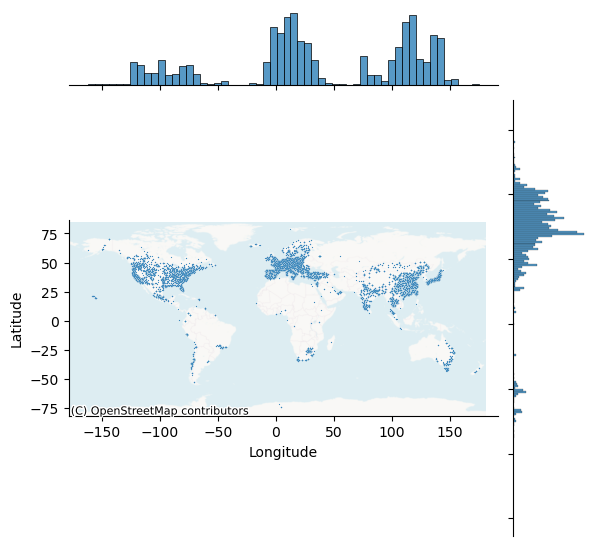

In [12]:
air_plot = sns.jointplot(x='Longitude', y='Latitude', data=air, s=0.7);
ctx.add_basemap(air_plot.ax_joint, crs="EPSG:4326",
    source=ctx.providers.OpenStreetMap.Mapnik, alpha = 0.4
)

In [13]:
#convert DataFrame into GeoDataframe

gair = gpd.GeoDataFrame(
    air, geometry=gpd.points_from_xy(air['Longitude'], air['Latitude']))

gair.head()

Country Code     City           Location Pollutant     Source Name Unit  \
0           JP  Unknown  北九州市小倉北区大門一丁目６－４８        NO  japan-soramame  ppm   
1           JP  Unknown   北九州市若松区本町三丁目１３－１       NO2  japan-soramame  ppm   
2           JP  Unknown   北九州市門司区大里原町１２－１２       NOX  japan-soramame  ppm   
3           JP  Unknown          千歳市若草４－１３       NO2  japan-soramame  ppm   
4           JP  Unknown    千葉市稲毛区宮野木町９９６－９       NOX  japan-soramame  ppm   

   Value               Last Updated Country Label   Latitude   Longitude  \
0  0.002  2024-03-10T13:30:00+05:30         Japan  33.880833  130.873056   
1  0.005  2024-03-10T13:30:00+05:30         Japan  33.898056  130.810000   
2  0.013  2024-03-10T13:30:00+05:30         Japan  33.895833  130.935833   
3  0.004  2024-03-10T13:30:00+05:30         Japan  42.786944  141.605000   
4  0.003  2024-03-10T13:30:00+05:30         Japan  35.653889  140.097778   

                     geometry  
0  POINT (130.87306 33.88083)  
1  POINT (130.81000 33.89806)  
2  POINT (130.93583 33.89583)  
3  POINT (141.60500 42.78694)  
4  POINT (140.09778 35.65389)

In [14]:
gair.set_crs(epsg=4326, inplace=True)
print(gair.crs)

EPSG:4326


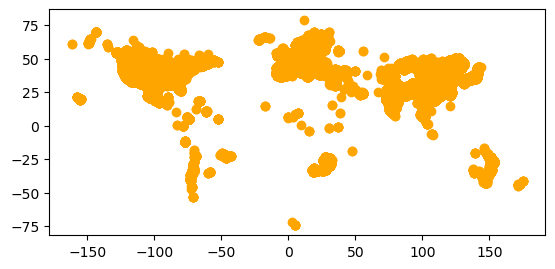

In [15]:
gair.plot(color='orange')

plt.show()

In [16]:
os_data=gpd.read_file('G:\LSY\Glasgow\Programming Tools for Urban Analytics\Summative Assessment\world-administrative-boundaries\world-administrative-boundaries.shp')

os_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

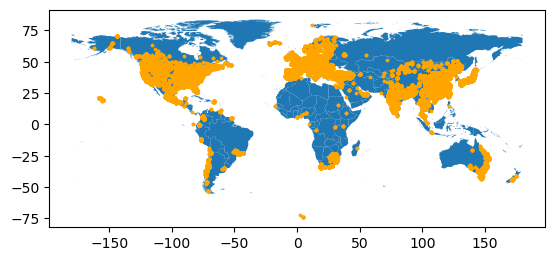

In [17]:
#Visualisation of the data
ax1 = os_data.plot()

## adding both datasets together
gair.plot(color='orange',ax = ax1, marker='o', markersize=3)

plt.show()

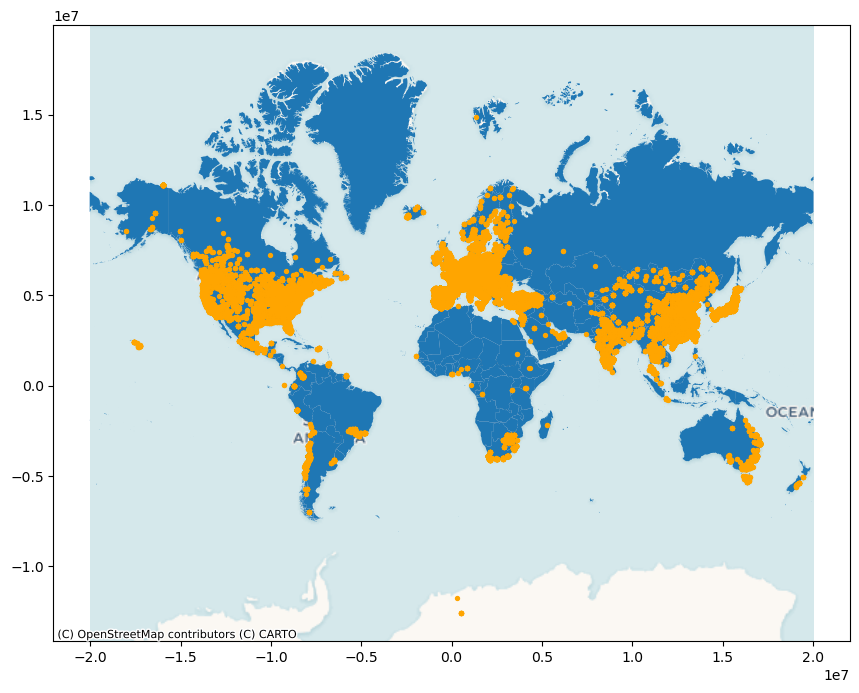

In [18]:
fig, ax = plt.subplots(figsize=(12,8))

#Reprojecting to align with background mapping, hence using webmerkator
os_data = os_data.to_crs(epsg= 3857)

# Plot the data
os_data.plot(ax=ax)
gair.to_crs(epsg= 3857).plot(color = 'orange',ax=ax, marker='o', markersize=8)
# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

In [19]:
os_data.head()

iso3        status color_code                                        name  \
0   UGA  Member State        UGA                                      Uganda   
1   UZB  Member State        UZB                                  Uzbekistan   
2   IRL  Member State        IRL                                     Ireland   
3   ERI  Member State        ERI                                     Eritrea   
4  None  UK Territory        GBR  South Georgia & the South Sandwich Islands   

    continent           region iso_3166_1_  \
0      Africa   Eastern Africa          UG   
1        Asia     Central Asia          UZ   
2      Europe  Northern Europe          IE   
3      Africa   Eastern Africa          ER   
4  Antarctica             None        None   

                                  french_shor  \
0                                     Ouganda   
1                                 Ouzbékistan   
2                                     Irlande   
3                                    Érythrée   
4  South Georgia & the South Sandwich Islands   

                                            geometry  
0  POLYGON ((3776079.579 -111541.136, 3775987.184...  
1  POLYGON ((7900434.430 5199204.443, 7901517.569...  
2  MULTIPOLYGON (((-1109870.908 7174102.234, -110...  
3  MULTIPOLYGON (((4467900.158 1776078.527, 44670...  
4  MULTIPOLYGON (((-2921425.302 -8071970.911, -29...

<Axes: >

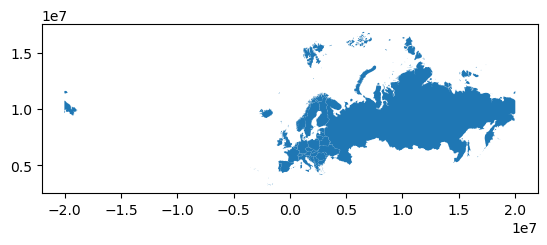

In [20]:
# Select Europe data
europe = os_data.loc[os_data['continent']=='Europe']

europe.plot()

In [21]:
europe.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

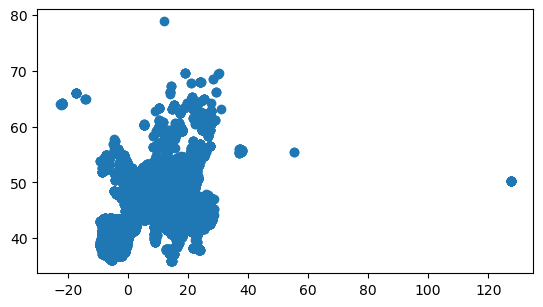

In [22]:
join = gpd.sjoin(gair,europe.to_crs(epsg=4326), how ='inner', predicate ='within')

join.plot()

In [23]:
len(join)

17457

In [24]:
join.head()

Country Code                             City    Location Pollutant  \
196            LT    Integrated Monitoring Network  NET-LT002A     PM2.5   
197            LT  National Air Monitoring Network  NET-LT001A        CO   
3161           LT    Integrated Monitoring Network  NET-LT002A       NO2   
5173           LT  National Air Monitoring Network  NET-LT001A        O3   
7722           LT  National Air Monitoring Network  NET-LT001A      PM10   

        Source Name   Unit       Value               Last Updated  \
196   EEA Lithuania  µg/m³    2.200000  2024-03-11T16:30:00+05:30   
197   EEA Lithuania  µg/m³  209.556000  2024-03-11T16:30:00+05:30   
3161  EEA Lithuania  µg/m³    3.060000  2024-03-11T16:30:00+05:30   
5173  EEA Lithuania  µg/m³   63.862400  2024-03-11T16:30:00+05:30   
7722  EEA Lithuania  µg/m³   32.919998  2024-03-11T16:30:00+05:30   

     Country Label   Latitude  ...                   geometry index_right  \
196      Lithuania  55.463333  ...  POINT (26.00417 55.46333)         127   
197      Lithuania  55.690000  ...  POINT (21.17946 55.69000)         127   
3161     Lithuania  56.008335  ...  POINT (21.88695 56.00834)         127   
5173     Lithuania  54.715279  ...  POINT (25.28944 54.71528)         127   
7722     Lithuania  55.707778  ...  POINT (21.14111 55.70778)         127   

      iso3        status color_code       name continent           region  \
196    LTU  Member State        LTU  Lithuania    Europe  Northern Europe   
197    LTU  Member State        LTU  Lithuania    Europe  Northern Europe   
3161   LTU  Member State        LTU  Lithuania    Europe  Northern Europe   
5173   LTU  Member State        LTU  Lithuania    Europe  Northern Europe   
7722   LTU  Member State        LTU  Lithuania    Europe  Northern Europe   

     iso_3166_1_ french_shor  
196           LT    Lituanie  
197           LT    Lituanie  
3161          LT    Lituanie  
5173          LT    Lituanie  
7722          LT    Lituanie  

[5 rows x 21 columns]

In [25]:
join.columns

Index(['Country Code', 'City', 'Location', 'Pollutant', 'Source Name', 'Unit',
       'Value', 'Last Updated', 'Country Label', 'Latitude', 'Longitude',
       'geometry', 'index_right', 'iso3', 'status', 'color_code', 'name',
       'continent', 'region', 'iso_3166_1_', 'french_shor'],
      dtype='object')

### 2.3 Data Distribution

The data were first analysed descriptively according to pollutants. We can tell that the air pollutant with the highest average is carbon monoxide (CO), which is very different from the mean values of the other pollutants, and the levels fluctuate very much, with a minimum of 0 and a maximum of 50,000. the pollutant with the lowest average is black carbon (BC), which is only 0.768802 μg/m3. the mean value of PM1 is also smaller, but it is not known if this is due to the fact that the data are bias introduced by the smaller amount of data.

The data were then analysed descriptively by country, with Macedonia having the highest average pollutant level of 220.76 μg/m3 and the largest standard deviation, implying that air pollution varies greatly from city to city in Macedonia. The lowest average pollutant levels were found in Iceland.

In [26]:
join.groupby('Pollutant')['Value'].describe()

count        mean          std  min         25%         50%  \
Pollutant                                                                 
BC          106.0    0.768802     0.948429  0.0    0.300000    0.500000   
CO         1176.0  516.887438  1838.034943  0.0  200.000000  312.500000   
NO         1762.0    9.849641    23.365415  0.0    1.000000    2.079750   
NO2        4116.0   19.301011    18.124618  0.0    6.759809   14.000000   
NOX         100.0   28.850000    27.846758  1.0   10.000000   20.500000   
O3         2783.0   51.013897    44.719399  0.0   32.808500   51.000000   
PM1          48.0   13.297676    10.749473  0.0    1.806250   12.593824   
PM10       3378.0   20.182734    21.429888  0.0    9.700000   16.000000   
PM2.5      2205.0   14.213528    24.251314  0.0    6.100000   11.000000   
SO2        1783.0    6.667078    75.564670  0.0    1.000125    2.700000   

                  75%           max  
Pollutant                            
BC           0.748615      5.417010  
CO         520.732250  50000.000000  
NO           8.000000    377.700000  
NO2         26.700000    427.800000  
NOX         38.000000    198.000000  
O3          71.000000   1996.000000  
PM1         21.340600     37.641369  
PM10        25.000000    580.880005  
PM2.5       17.200000    898.163000  
SO2          5.000000   3052.620000

In [27]:
join.groupby('Country Label')['Value'].describe()

count        mean         std       min        25%  \
Country Label                                                                 
Andorra                    9.0   36.600000   42.739677  0.200000   4.700000   
Austria                 1186.0   44.028805  118.893780  0.000000   6.651993   
Belgium                  423.0   34.040828   78.815001  0.000000  11.000000   
Bosnia and Herzegovina    90.0  139.651111  319.377085  0.000000  13.250000   
Bulgaria                 141.0   95.700130  224.476234  1.350000   8.610000   
Croatia                   56.0   64.667696  118.299441  1.000000   6.700000   
Czech Republic           439.0   35.336489   89.297165  0.250000   4.700000   
Denmark                   23.0   44.507303   69.565155  1.627976   9.035000   
Estonia                   27.0   45.489253   76.472751  0.262059   4.131500   
Finland                  155.0   16.625981   24.487585  0.000000   1.905280   
France                  2360.0   25.756891   45.381595  0.000000   5.200000   
Germany                 2191.0   36.918938  115.631354  0.000000   4.686069   
Gibraltar                  4.0  143.050000  219.179782  1.500000  38.025000   
Greece                   173.0  136.630058  348.822974  1.000000   8.000000   
Hungary                  437.0  150.566835  347.262625  0.300000   9.800000   
Iceland                   63.0    8.310553   15.660026  0.000000   1.575780   
Ireland                   76.0   34.771914   75.629884  0.000000  10.537500   
Italy                   2089.0   87.145513  800.373778  0.000000   6.600000   
Kosovo                    87.0   15.217966   17.737266  0.000000   4.500000   
Latvia                    39.0   35.467791   59.992675  0.000000   5.500000   
Lithuania                 63.0   68.859053  109.907191  0.266090   6.115035   
Luxembourg                32.0   37.812500   68.269748  0.600000   5.325000   
Macedonia                143.0  220.762266  940.791629  0.000000   3.105250   
Malta                     13.0   41.080203   55.090356  0.094910   7.623860   
Moldova, Republic of       3.0   11.981991    6.390109  5.275532   8.972987   
Montenegro                32.0   90.696875  229.727924  2.000000   7.525000   
Netherlands              205.0   25.634478   23.552351  0.260000   7.200000   
Norway                   193.0   19.299595   26.448403  0.000000   7.707419   
Poland                  1215.0   64.755909  223.892383  0.000000   5.000000   
Portugal                 199.0   52.845729  269.647884  0.000000   4.200000   
Romania                  111.0   32.861016   30.762702  3.013266   9.524846   
Russian Federation       139.0  120.972400  172.187829  0.000000  11.000000   
Serbia                   297.0   58.865583  150.418365  0.972390   8.995792   
Slovakia                 311.0   79.524429  205.155626  0.276858  12.381000   
Slovenia                  25.0   16.643884   19.675610  0.070089   7.000000   
Spain                   3203.0   58.831125  888.658933  0.000000   2.850000   
Sweden                   291.0   30.219519   62.337414  0.000000   6.347775   
Switzerland              139.0   31.951584   49.227154  0.000000   2.774350   
United Kingdom           775.0   27.787338   25.354484  0.000000  13.000000   

                              50%         75%           max  
Country Label                                                
Andorra                 11.000000   50.500000    108.700000  
Austria                 18.000000   38.604354   2107.602110  
Belgium                 19.000000   28.900000   1045.000000  
Bosnia and Herzegovina  30.700000   90.000000   1736.000000  
Bulgaria                20.020000   37.850000   1250.000000  
Croatia                 19.350000   69.200000    600.000000  
Czech Republic          14.000000   29.337202    949.000060  
Denmark                 22.790000   39.660000    300.000000  
Estonia                  7.033500   50.296300    253.279000  
Finland                  6.393430   17.842096     98.170620  
France                  13.400000   33.70

## 3 Data Visualization and Analysis

Next I will visualise the data at an aggregate level and at the level of individual pollutants.

### 3.1 General Data

The data are visualised in the order of pollutant, data source and country. From Figure 1 we can conclude that the pollutant with the highest number of occurrences is nitrogen dioxide, while BC, NOX and PM1 have a very low number of occurrences, which is consistent with the fact that their counts in the descriptive analysis are also very low. Looking at Figures 2 and 3 we can see that the organisation of the data sources for the 15 countries with the highest number of occurrences is also similar.

The top 50 locations with the highest concentrations of pollutants were then identified as belonging to countries and a bar graph was created to show the number of these countries. In Figure 4, Hungary accounts for 12 of the top 50 areas with the highest pollutant concentrations, but Hungary occurs more frequently in the dataset (although not particularly so), and we are still unsure whether the air environment in Hungary is particularly poor. However, with Macedonia having 4 areas of the top 50 pollution concentrations and not appearing with high frequency in the dataset, it is possible to determine that Macedonia's air environment is not very good, which is also consistent with the conclusions of the descriptive analyses in 2.3. Combined with the descriptive analyses we can tell that parts of Macedonia have an extremely poor air environment.

The geoplot is then plotted against the spatial geographic data. The data is divided into quartiles based on the values in the 'Value' column and the geographic coordinate points are coloured according to the magnitude of the value.

Geographic data is projected transformed, cropped, visualised and an underlay added for better presentation and understanding of air quality data and European geographic information.

Cropped geojson files with world boundaries to geojson files with European data only. The Value was also changed to the average pollution value of the country, where the spatial distribution of the data for each country was shown and the data was presented using different visualisations.

In [29]:
print(join["Source Name"].nunique())
print(join["Country Label"].nunique())

53
39


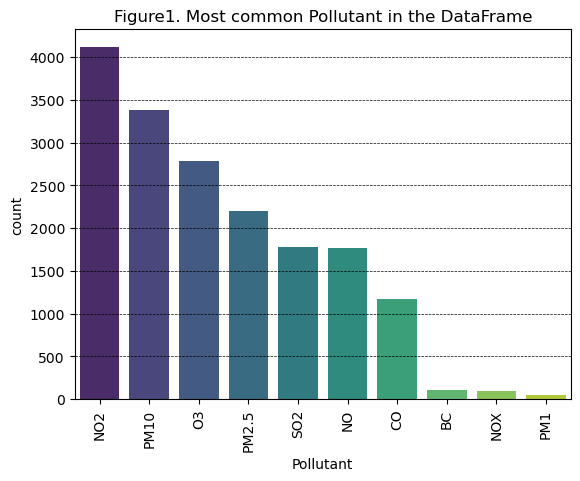

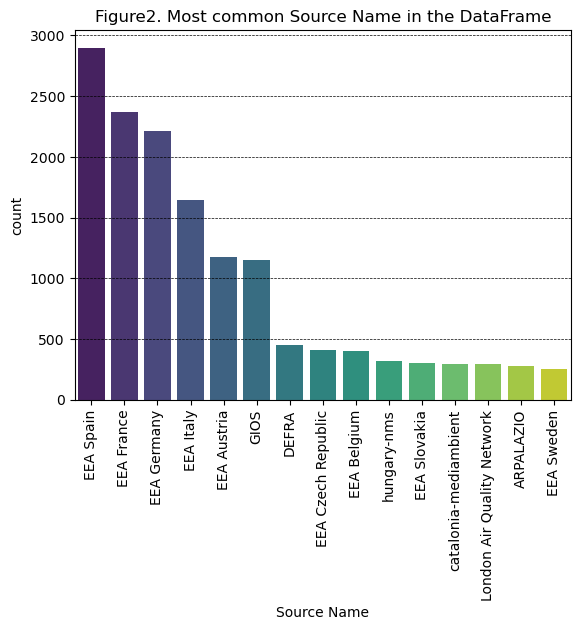

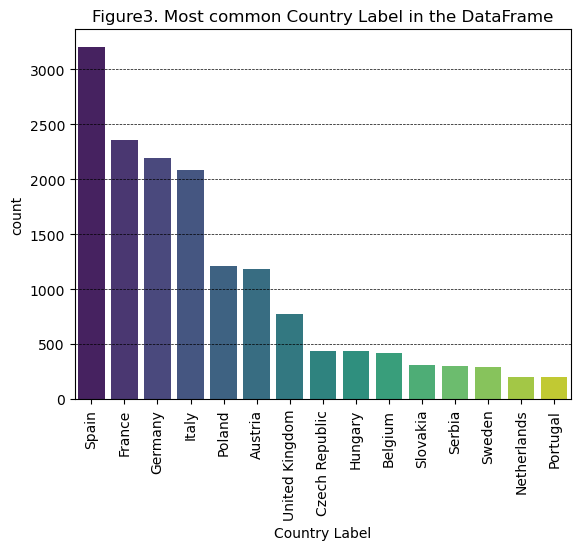

In [30]:
for i, column in enumerate(['Pollutant', 'Source Name', 'Country Label'], start=1): 
    sns.barplot(x = join[column].value_counts()[:15].index, y = join[column].value_counts()[:15], palette='viridis')
    plt.xticks(rotation = 90)
    plt.grid(color='black', linestyle='--', linewidth=0.5, which ='both', axis='y')
    plt.title(f'Figure{i}. Most common {column} in the DataFrame')
    plt.show()

In [31]:
join['Unit'].unique()

array(['µg/m³'], dtype=object)

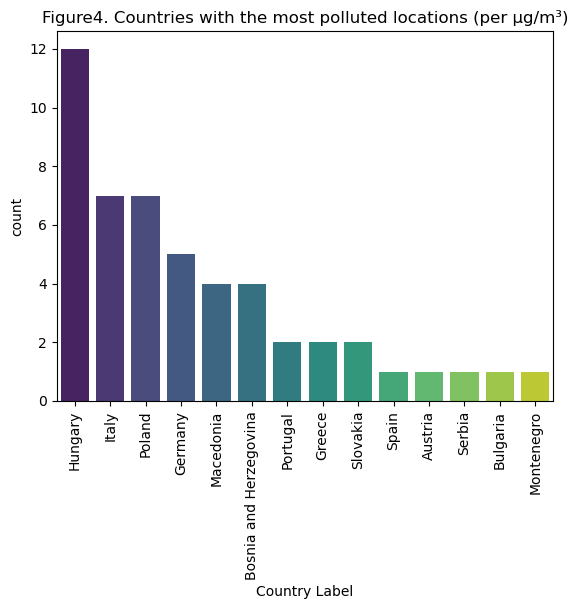

In [32]:
pollution = join.loc[join['Unit'] == 'µg/m³'].sort_values(by = 'Value', ascending= False)[:50]
pollution = pollution['Country Label'].value_counts()
sns.barplot(x = pollution.index, y = pollution, palette='viridis')
plt.title(f'Figure4. Countries with the most polluted locations (per µg/m³)')
plt.xticks(rotation = 90)
plt.show()

D:\download\Lib\site-packages\geoplot\geoplot.py:708: UserWarning: Could not set plot extent successfully due to numerical instability. Try setting extent manually. Defaulting to a global extent.
  warnings.warn(


<GeoAxes: >

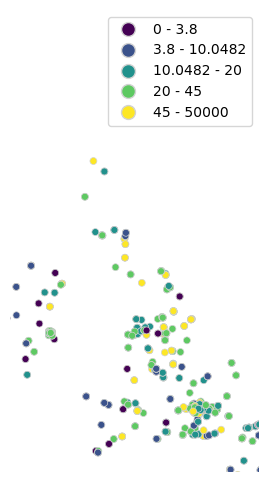

In [33]:
scheme = mc.Quantiles(join['Value'])

geoplot.pointplot(
    join, projection=geoplot.crs.OSGB(),
    hue='Value',
    legend=True,
    edgecolor='lightgray', linewidth=0.5, scheme=scheme
)

In [34]:
print(europe.crs)
print(gair.crs)

EPSG:3857
EPSG:4326


In [35]:
gair.to_crs(epsg=3857,inplace =True)
europe.to_crs(epsg = 3857,inplace=True)

D:\download\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [36]:
clipped = gpd.clip(gair, europe)

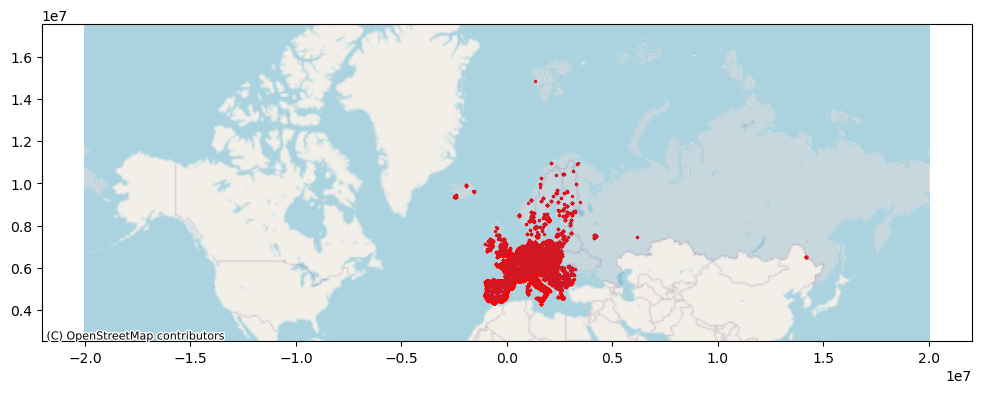

In [37]:
fig, ax1 = plt.subplots(figsize=(12,8))

clipped.plot(ax=ax1, marker='o', markersize=2, color='red')
europe.plot(ax=ax1,alpha=0.2 )

ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)

In [38]:
print(len(clipped))

17457


In [39]:
assert len(clipped) == len(join)

In [40]:
clipped.head()

Country Code  City Location Pollutant            Source Name   Unit  \
53192           ES  Gavà     Gavà       SO2  catalonia-mediambient  µg/m³   
16674           ES  Gavà     Gavà        CO  catalonia-mediambient  µg/m³   
21049           ES  Gavà     Gavà       NO2  catalonia-mediambient  µg/m³   
45191           ES  Gavà     Gavà        NO  catalonia-mediambient  µg/m³   
9399            ES  Gavà     Gavà       NOX  catalonia-mediambient  µg/m³   

       Value               Last Updated Country Label   Latitude  Longitude  \
53192    3.0  2024-03-20T20:30:00+05:30         Spain  41.303097   1.991498   
16674  300.0  2024-03-20T20:30:00+05:30         Spain  41.303097   1.991498   
21049    8.0  2024-03-20T20:30:00+05:30         Spain  41.303097   1.991498   
45191    3.0  2024-03-20T20:30:00+05:30         Spain  41.303097   1.991498   
9399    12.0  2024-03-20T20:30:00+05:30         Spain  41.303097   1.991498   

                             geometry  
53192  POINT (221692.554 5057151.721)  
16674  POINT (221692.554 5057151.721)  
21049  POINT (221692.554 5057151.721)  
45191  POINT (221692.554 5057151.721)  
9399   POINT (221692.554 5057151.721)

In [41]:
clipped_wgs84 = clipped.to_crs(epsg = 4326)

<Axes: >

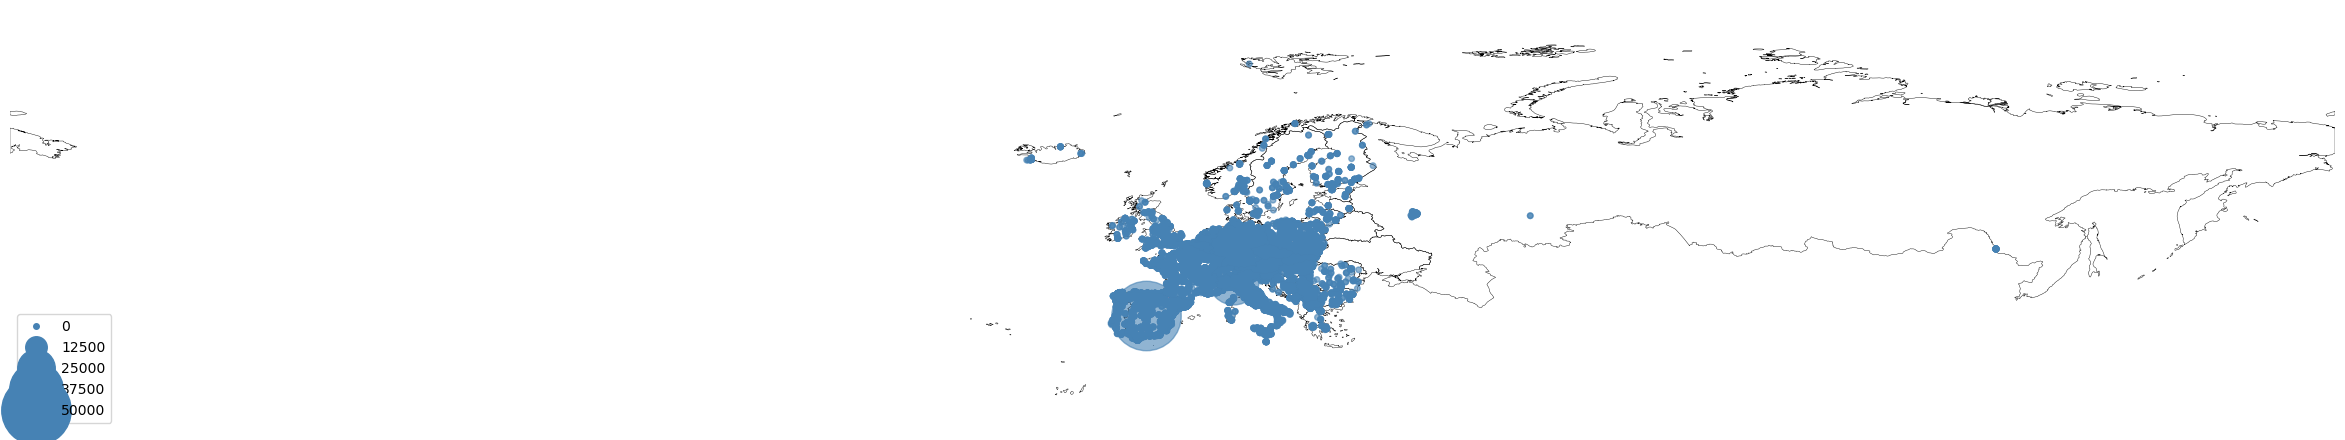

In [42]:
europe_exploded = europe.explode(index_parts=True)
ax = geoplot.pointplot(
    clipped_wgs84, 
    scale='Value', limits=(4, 50),
    figsize=(30,15), alpha = 0.6, legend = True
)
geoplot.polyplot(europe_exploded.to_crs(epsg=4326), linewidth=0.3, ax=ax)


In [43]:
world_dz=gpd.read_file('G:\LSY\Glasgow\Programming Tools for Urban Analytics\Summative Assessment\world-administrative-boundaries.geojson')

europe_data = world_dz[world_dz['continent'] == 'Europe']

europe_data.to_file('europe_boundaries.geojson', driver='GeoJSON')

In [44]:
dz=gpd.read_file('G:\LSY\Glasgow\Programming Tools for Urban Analytics\Summative Assessment\europe_boundaries.geojson')

In [45]:
dz.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [46]:
gair.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [47]:
gair.to_crs(epsg=4326,inplace = True)
gair.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

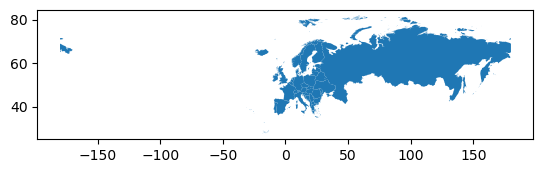

In [48]:
dz.plot()

In [49]:
dz_join = gpd.sjoin(gair, dz, predicate="within")

In [50]:
dz_join.head()

Country Code                             City    Location Pollutant  \
196            LT    Integrated Monitoring Network  NET-LT002A     PM2.5   
197            LT  National Air Monitoring Network  NET-LT001A        CO   
3161           LT    Integrated Monitoring Network  NET-LT002A       NO2   
5173           LT  National Air Monitoring Network  NET-LT001A        O3   
7722           LT  National Air Monitoring Network  NET-LT001A      PM10   

        Source Name   Unit       Value               Last Updated  \
196   EEA Lithuania  µg/m³    2.200000  2024-03-11T16:30:00+05:30   
197   EEA Lithuania  µg/m³  209.556000  2024-03-11T16:30:00+05:30   
3161  EEA Lithuania  µg/m³    3.060000  2024-03-11T16:30:00+05:30   
5173  EEA Lithuania  µg/m³   63.862400  2024-03-11T16:30:00+05:30   
7722  EEA Lithuania  µg/m³   32.919998  2024-03-11T16:30:00+05:30   

     Country Label   Latitude  ...  index_right  \
196      Lithuania  55.463333  ...           25   
197      Lithuania  55.690000  ...           25   
3161     Lithuania  56.008335  ...           25   
5173     Lithuania  54.715279  ...           25   
7722     Lithuania  55.707778  ...           25   

                                           geo_point_2d  iso3        status  \
196   {'lon': 23.89812325011703, 'lat': 55.335670485...   LTU  Member State   
197   {'lon': 23.89812325011703, 'lat': 55.335670485...   LTU  Member State   
3161  {'lon': 23.89812325011703, 'lat': 55.335670485...   LTU  Member State   
5173  {'lon': 23.89812325011703, 'lat': 55.335670485...   LTU  Member State   
7722  {'lon': 23.89812325011703, 'lat': 55.335670485...   LTU  Member State   

     color_code       name continent           region  \
196         LTU  Lithuania    Europe  Northern Europe   
197         LTU  Lithuania    Europe  Northern Europe   
3161        LTU  Lithuania    Europe  Northern Europe   
5173        LTU  Lithuania    Europe  Northern Europe   
7722        LTU  Lithuania    Europe  Northern Europe   

     iso_3166_1_alpha_2_codes french_short  
196                        LT     Lituanie  
197                        LT     Lituanie  
3161                       LT     Lituanie  
5173                       LT     Lituanie  
7722                       LT     Lituanie  

[5 rows x 22 columns]

In [51]:
dz_join.describe()

Value      Latitude     Longitude   index_right
count  17457.000000  17457.000000  17457.000000  17457.000000
mean      55.086190     47.164446      8.599965     18.301197
std      494.164516      5.399253     10.214437     14.210023
min        0.000000     35.852291    -22.583994      0.000000
25%        5.100000     43.168320      0.232486      4.000000
50%       14.500000     47.445833      9.169289     16.000000
75%       35.773000     50.850321     15.632500     33.000000
max    50000.000000     78.906690    127.529100     51.000000

In [52]:
dz_join.groupby('Country Label')['Value'].describe()

count        mean         std       min        25%  \
Country Label                                                                 
Andorra                    9.0   36.600000   42.739677  0.200000   4.700000   
Austria                 1186.0   44.028805  118.893780  0.000000   6.651993   
Belgium                  423.0   34.040828   78.815001  0.000000  11.000000   
Bosnia and Herzegovina    90.0  139.651111  319.377085  0.000000  13.250000   
Bulgaria                 141.0   95.700130  224.476234  1.350000   8.610000   
Croatia                   56.0   64.667696  118.299441  1.000000   6.700000   
Czech Republic           439.0   35.336489   89.297165  0.250000   4.700000   
Denmark                   23.0   44.507303   69.565155  1.627976   9.035000   
Estonia                   27.0   45.489253   76.472751  0.262059   4.131500   
Finland                  155.0   16.625981   24.487585  0.000000   1.905280   
France                  2360.0   25.756891   45.381595  0.000000   5.200000   
Germany                 2191.0   36.918938  115.631354  0.000000   4.686069   
Gibraltar                  4.0  143.050000  219.179782  1.500000  38.025000   
Greece                   173.0  136.630058  348.822974  1.000000   8.000000   
Hungary                  437.0  150.566835  347.262625  0.300000   9.800000   
Iceland                   63.0    8.310553   15.660026  0.000000   1.575780   
Ireland                   76.0   34.771914   75.629884  0.000000  10.537500   
Italy                   2089.0   87.145513  800.373778  0.000000   6.600000   
Kosovo                    87.0   15.217966   17.737266  0.000000   4.500000   
Latvia                    39.0   35.467791   59.992675  0.000000   5.500000   
Lithuania                 63.0   68.859053  109.907191  0.266090   6.115035   
Luxembourg                32.0   37.812500   68.269748  0.600000   5.325000   
Macedonia                143.0  220.762266  940.791629  0.000000   3.105250   
Malta                     13.0   41.080203   55.090356  0.094910   7.623860   
Moldova, Republic of       3.0   11.981991    6.390109  5.275532   8.972987   
Montenegro                32.0   90.696875  229.727924  2.000000   7.525000   
Netherlands              205.0   25.634478   23.552351  0.260000   7.200000   
Norway                   193.0   19.299595   26.448403  0.000000   7.707419   
Poland                  1215.0   64.755909  223.892383  0.000000   5.000000   
Portugal                 199.0   52.845729  269.647884  0.000000   4.200000   
Romania                  111.0   32.861016   30.762702  3.013266   9.524846   
Russian Federation       139.0  120.972400  172.187829  0.000000  11.000000   
Serbia                   297.0   58.865583  150.418365  0.972390   8.995792   
Slovakia                 311.0   79.524429  205.155626  0.276858  12.381000   
Slovenia                  25.0   16.643884   19.675610  0.070089   7.000000   
Spain                   3203.0   58.831125  888.658933  0.000000   2.850000   
Sweden                   291.0   30.219519   62.337414  0.000000   6.347775   
Switzerland              139.0   31.951584   49.227154  0.000000   2.774350   
United Kingdom           775.0   27.787338   25.354484  0.000000  13.000000   

                              50%         75%           max  
Country Label                                                
Andorra                 11.000000   50.500000    108.700000  
Austria                 18.000000   38.604354   2107.602110  
Belgium                 19.000000   28.900000   1045.000000  
Bosnia and Herzegovina  30.700000   90.000000   1736.000000  
Bulgaria                20.020000   37.850000   1250.000000  
Croatia                 19.350000   69.200000    600.000000  
Czech Republic          14.000000   29.337202    949.000060  
Denmark                 22.790000   39.660000    300.000000  
Estonia                  7.033500   50.296300    253.279000  
Finland                  6.393430   17.842096     98.170620  
France                  13.400000   33.70

In [53]:
pollution = dz_join.groupby('Country Label')['Value'].mean().reset_index()
pollution.head(100)

Country Label       Value
0                  Andorra   36.600000
1                  Austria   44.028805
2                  Belgium   34.040828
3   Bosnia and Herzegovina  139.651111
4                 Bulgaria   95.700130
5                  Croatia   64.667696
6           Czech Republic   35.336489
7                  Denmark   44.507303
8                  Estonia   45.489253
9                  Finland   16.625981
10                  France   25.756891
11                 Germany   36.918938
12               Gibraltar  143.050000
13                  Greece  136.630058
14                 Hungary  150.566835
15                 Iceland    8.310553
16                 Ireland   34.771914
17                   Italy   87.145513
18                  Kosovo   15.217966
19                  Latvia   35.467791
20               Lithuania   68.859053
21              Luxembourg   37.812500
22               Macedonia  220.762266
23                   Malta   41.080203
24    Moldova, Republic of   11.981991
25              Montenegro   90.696875
26             Netherlands   25.634478
27                  Norway   19.299595
28                  Poland   64.755909
29                Portugal   52.845729
30                 Romania   32.861016
31      Russian Federation  120.972400
32                  Serbia   58.865583
33                Slovakia   79.524429
34                Slovenia   16.643884
35                   Spain   58.831125
36                  Sweden   30.219519
37             Switzerland   31.951584
38          United Kingdom   27.787338

In [54]:
pollution.rename(columns={'Value':'Value_mean'},inplace= True)
pollution_dz = pd.merge(pollution, dz, left_on='Country Label', right_on='name')
pollution_dz.head()

Country Label  Value_mean  \
0       Andorra   36.600000   
1       Austria   44.028805   
2       Belgium   34.040828   
3      Bulgaria   95.700130   
4       Croatia   64.667696   

                                        geo_point_2d iso3        status  \
0  {'lon': 1.5767650843354541, 'lat': 42.54865286...  AND  Member State   
1  {'lon': 14.14019348879525, 'lat': 47.592902606...  AUT  Member State   
2  {'lon': 4.663989187136802, 'lat': 50.642851163...  BEL  Member State   
3  {'lon': 25.231506244029507, 'lat': 42.76137671...  BGR  Member State   
4  {'lon': 16.41177821249749, 'lat': 45.051161869...  HRV  Member State   

  color_code      name continent           region iso_3166_1_alpha_2_codes  \
0        AND   Andorra    Europe  Southern Europe                       AD   
1        AUT   Austria    Europe   Western Europe                       AT   
2        BEL   Belgium    Europe   Western Europe                       BE   
3        BGR  Bulgaria    Europe   Eastern Europe                       BG   
4        HRV   Croatia    Europe  Southern Europe                       HR   

  french_short                                           geometry  
0      Andorre  POLYGON ((1.72361 42.50944, 1.71889 42.50305, ...  
1     Autriche  POLYGON ((16.94618 48.61907, 16.94333 48.57333...  
2     Belgique  POLYGON ((6.01180 50.75727, 6.05472 50.72361, ...  
3     Bulgarie  POLYGON ((28.58324 43.74776, 28.57638 43.73305...  
4      Croatie  MULTIPOLYGON (((17.74555 42.69305, 17.74000 42...

In [55]:
type(pollution_dz)

pandas.core.frame.DataFrame

<Axes: >

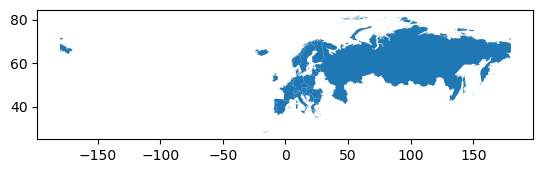

In [56]:
pollution_dz_gdf = gpd.GeoDataFrame(pollution_dz,geometry = 'geometry')
pollution_dz_gdf.plot()

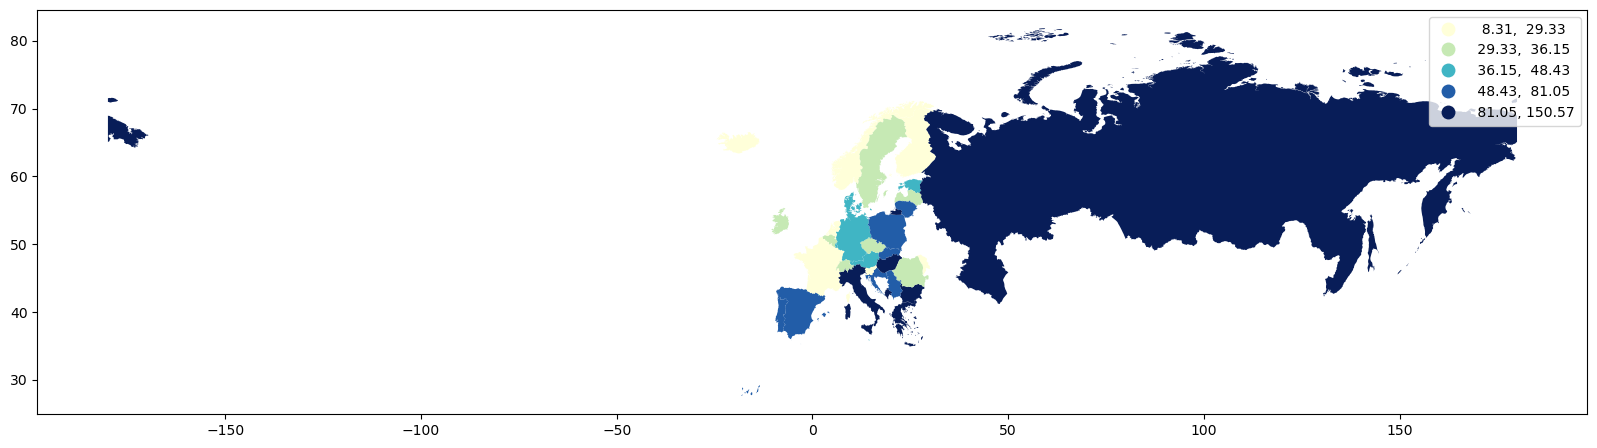

In [57]:
pollution_dz_gdf.plot(column='Value_mean', cmap =    
                                'YlGnBu', figsize=(20,12),   
                                 scheme='quantiles', k=5, legend =  
                                  True);

<Axes: >

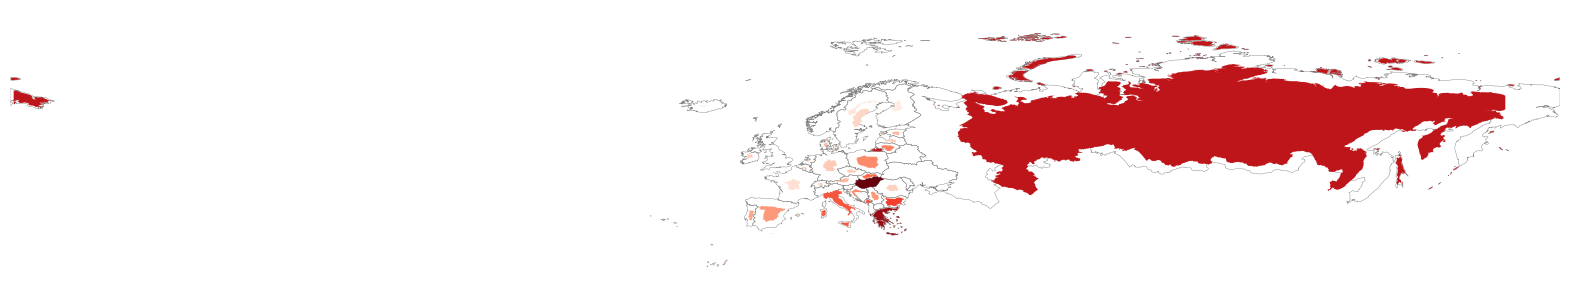

In [58]:
pollution_dz_gdf_exploded = pollution_dz_gdf.explode(index_parts=True)

ax2 = geoplot.cartogram(
    pollution_dz_gdf_exploded.to_crs(epsg=4326), scale='Value_mean',
    edgecolor='None', hue='Value_mean', cmap='Reds',
    figsize=(20, 12)
)

dz_exploded = dz.explode(index_parts=True)

geoplot.polyplot(dz_exploded.to_crs(epsg=4326), edgecolor='grey', linewidth=0.3, zorder=0, ax=ax2)

### 3.2 Specific Data

The bar chart analyses the countries with the highest and lowest average concentrations of each pollutant in turn.
The country with the highest average concentration of NO2 is Gibraltar, which is significantly higher than the other countries, while Estonia, Andorra, Malta, and Slovenia all have very low average concentrations of NO2.
The country with the highest average PM2.5 concentration is Bosnia and Herzegovina, and the country with the lowest average concentration is Denmark, which is significantly lower than the other countries.
The country with the highest average O3 concentration is Portugal, and the country with the lowest average concentration is Bulgaria.
Both Lithuania and Bosnia and Herzegovina have very high average PM10 concentrations, which are significantly higher than in the other countries, and the country with the lowest average PM10 concentration is Iceland.
The country with the highest average concentration of SO2 is Bosnia and Herzegovina, which is significantly higher than the other countries, and the country with the lowest average concentration of SO2 is Malta.
The countries with the highest average CO concentrations are Macedonia, Netherland with an average CO concentration of 0, and Kosovo with a very low average CO concentration, significantly lower than the other countries.
The country with the highest average NO concentration is Macedonia, while Andorra, Poland, Slovakia and Iceland all have very low average NO concentrations.
NOX is present only in Italy and Spain, and BC is present only in Poland.
The country with the highest average PM1 concentration is Czech Republic, France has an average PM1 concentration of 0, and Iceland has a very low average CO concentration.

The country Spain has been chosen to show clearly, using pie charts, information about the main pollutants in Spain, the cities analysed and the most polluted cities for certain pollutants. It can be seen that although the concentration of pollution in Spain is not particularly high, there is widespread pollution in most of the cities and the concentration of pollutants is more balanced.

Finally a geographical visualisation of the country was made for the different pollutants in turn.

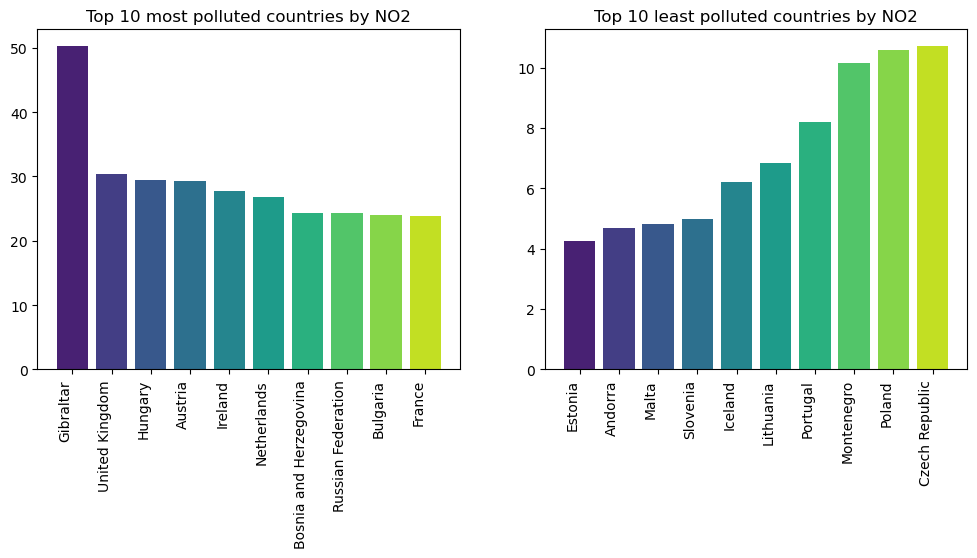

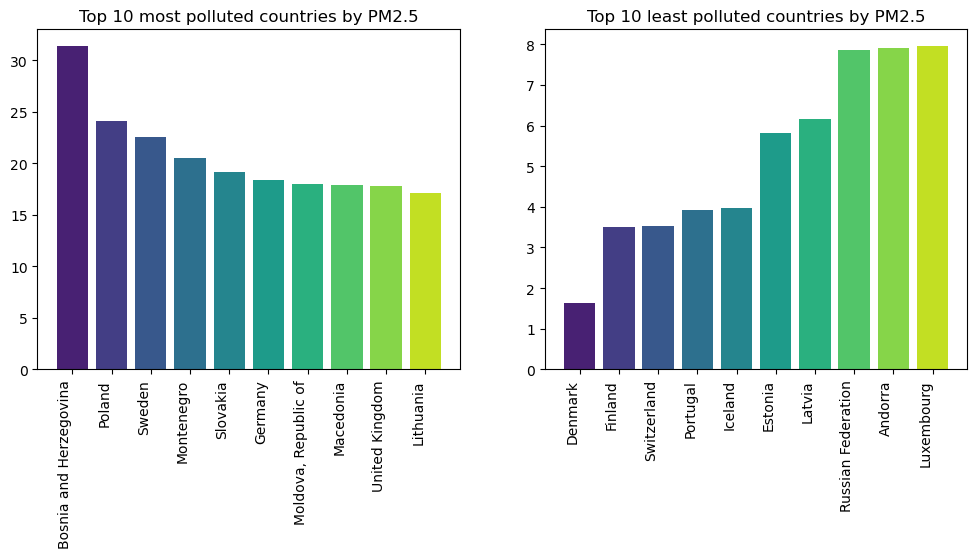

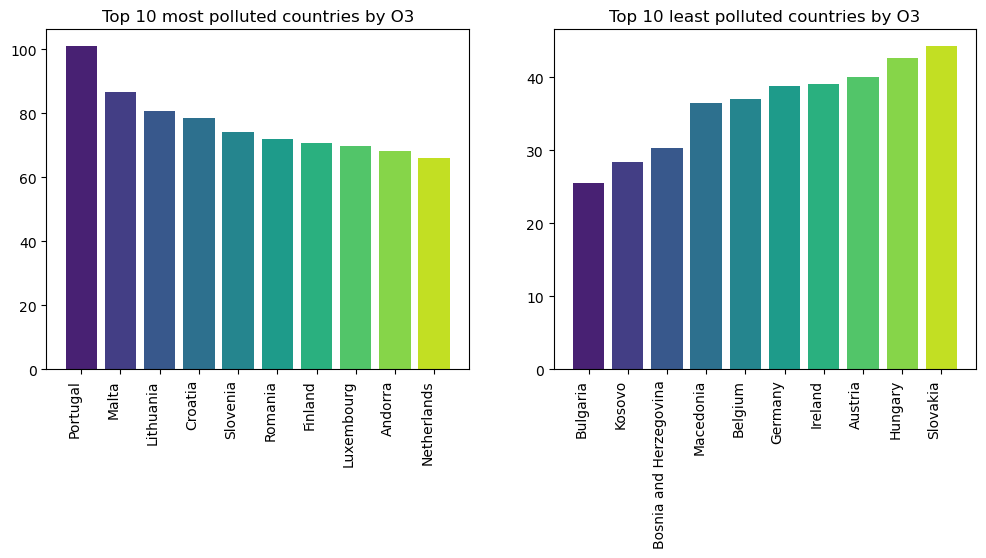

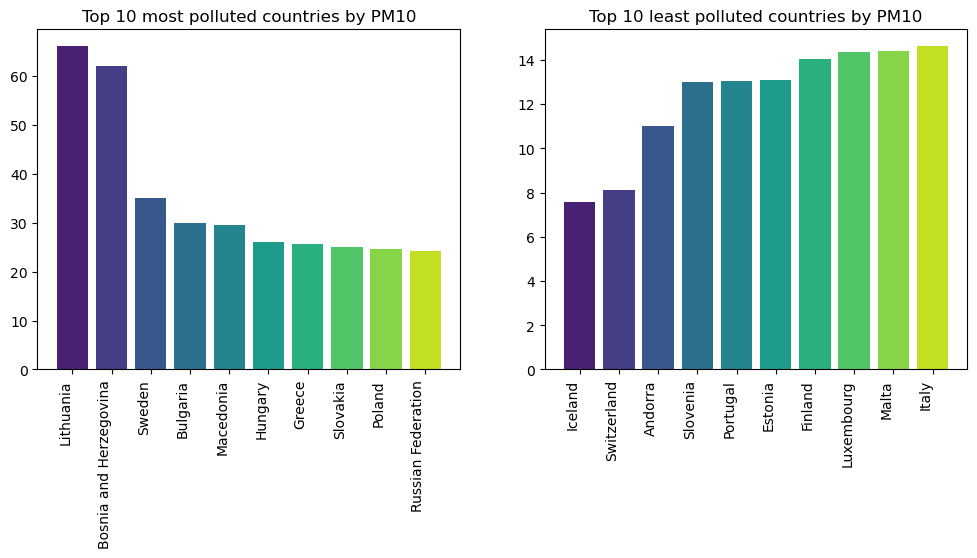

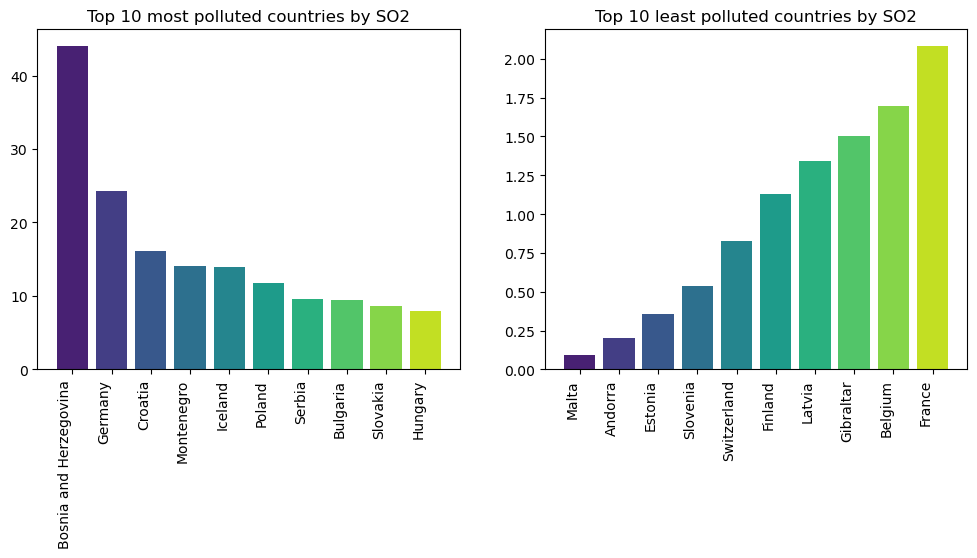

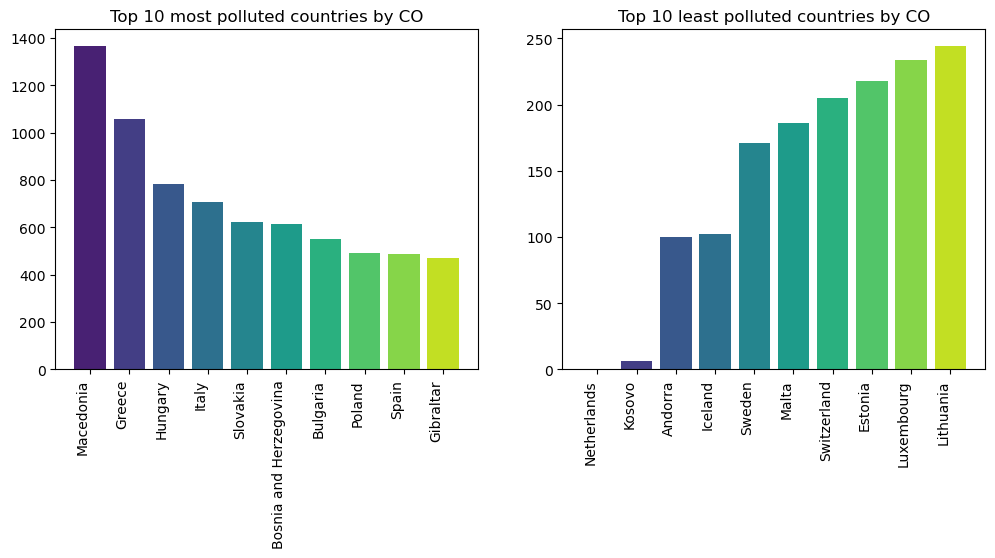

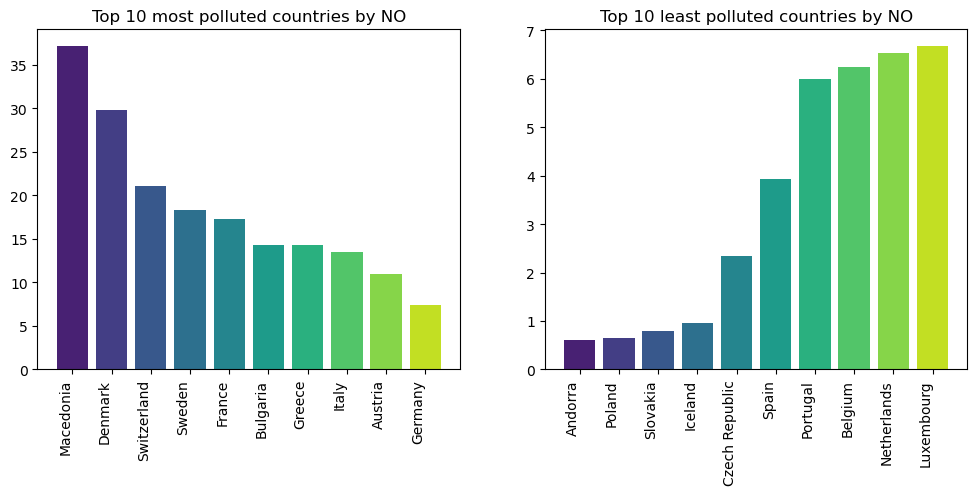

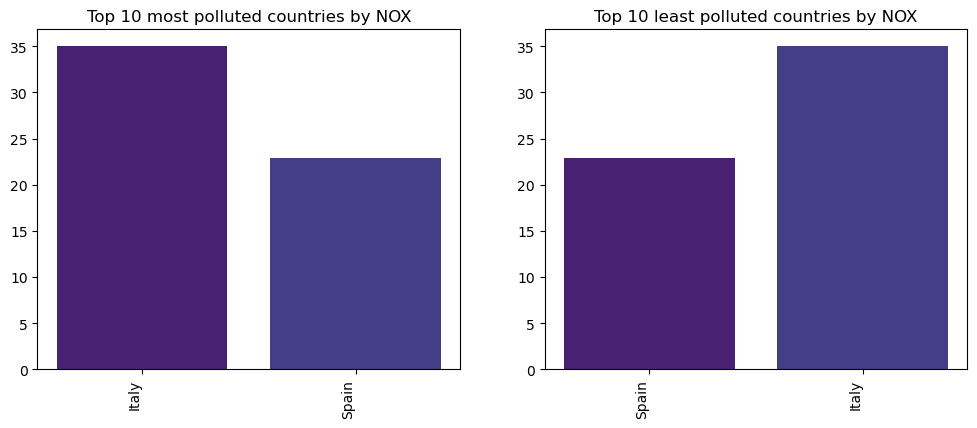

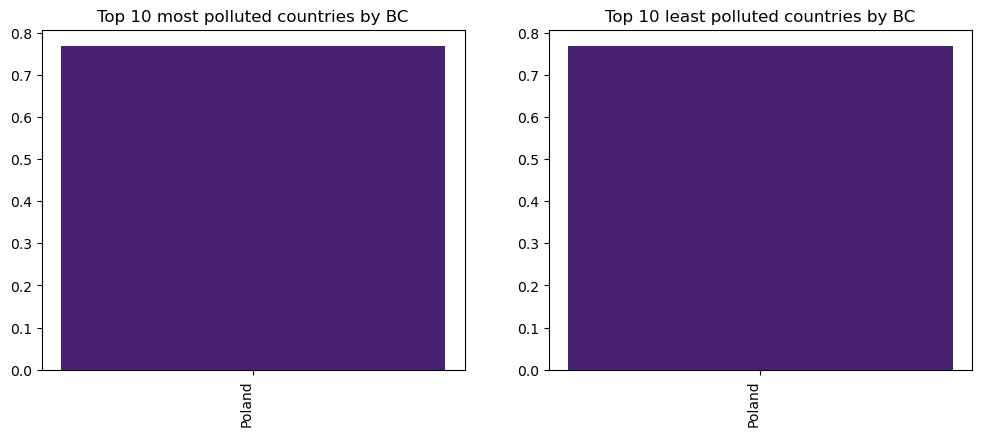

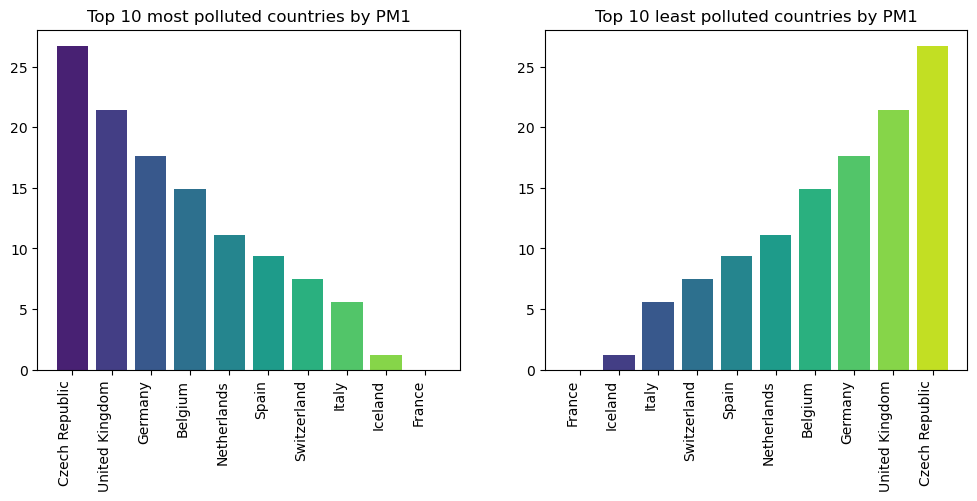

In [59]:
for type in ['NO2', 'PM2.5', 'O3', 'PM10', 'SO2', 'CO', 'NO', 'NOX', 'BC', 'PM1']:
   fig, axs= plt.subplots(1, 2, figsize=(12, 5))
   pollutant = join.loc[join['Pollutant'] == type].groupby('Country Label')['Value'].mean().sort_values(ascending=False)
   
   axs[0].bar(x = pollutant[:10].index, height = pollutant[:10], color = sns.color_palette('viridis', 10))
   pollutant = pollutant.sort_values(ascending=True)
   axs[1].bar(x = pollutant[:10].index, height = pollutant[:10], color = sns.color_palette('viridis', 10))
   
   fig.autofmt_xdate(rotation=90)
   axs[0].set_title(f'Top 10 most polluted countries by {type}')
   axs[1].set_title(f'Top 10 least polluted countries by {type}')
   plt.show()

C:\Users\HW\AppData\Local\Temp\ipykernel_27284\1751633417.py:36: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate(rotation=90)


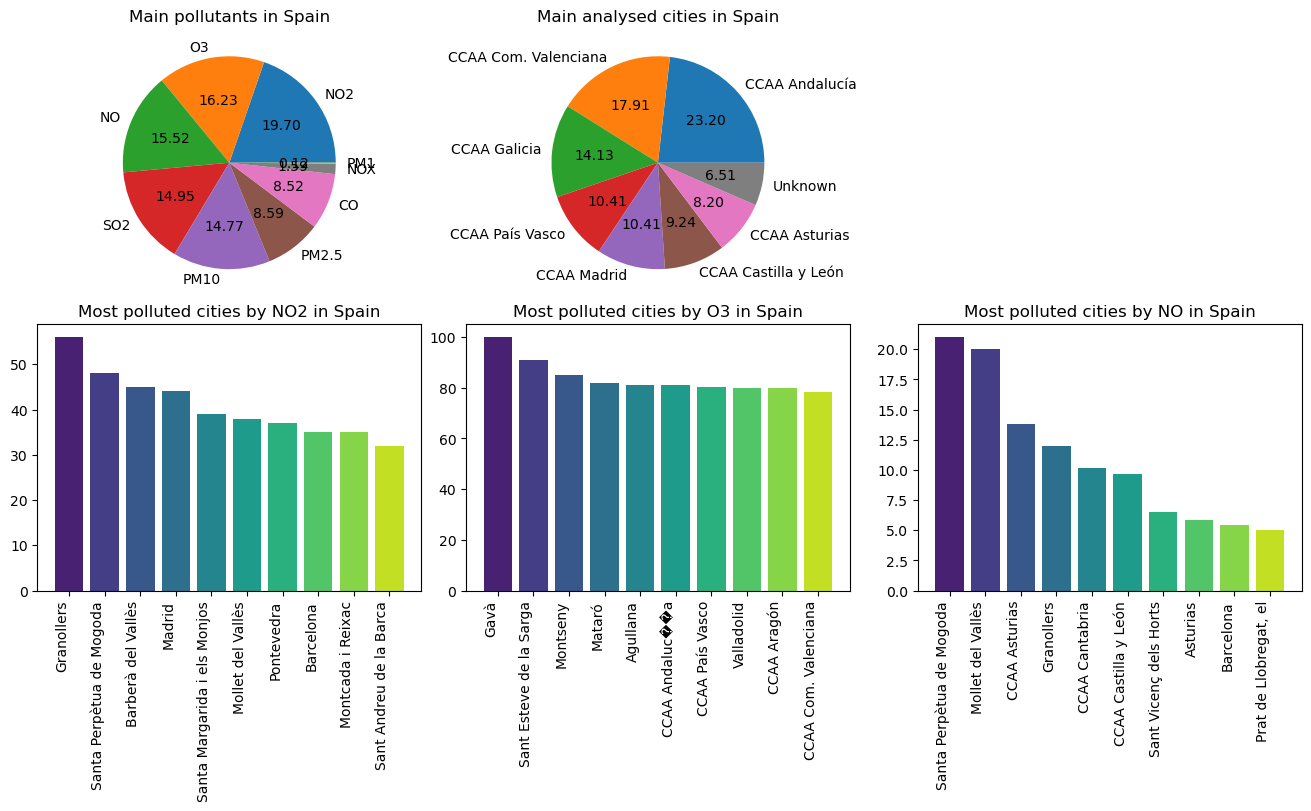

In [60]:
fig = plt.figure(layout="constrained", figsize=(13,8))

gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])

#Variables creation
country_to_search = 'Spain'
country_info = join.loc[join['Country Label'] == country_to_search]
contaminated_locations = country_info.groupby('City')['Value'].mean().sort_values(ascending=False)

country_pollutants = country_info['Pollutant'].value_counts()
country_cities = country_info['City'].value_counts()
country_NO2 = country_info.loc[country_info['Pollutant'] == 'NO2'].groupby('City')['Value'].mean().sort_values(ascending=False)
country_O3 = country_info.loc[country_info['Pollutant'] == 'O3'].groupby('City')['Value'].mean().sort_values(ascending=False)
country_NO = country_info.loc[country_info['Pollutant'] == 'NO'].groupby('City')['Value'].mean().sort_values(ascending=False)
#ax1
ax1.pie(country_pollutants, labels=country_pollutants.index, autopct='%.2f')
ax1.set_title(f'Main pollutants in {country_to_search}')
#ax2
ax2.pie(country_cities[:8], labels=country_cities[:8].index, autopct='%.2f')
ax2.set_title(f'Main analysed cities in {country_to_search}')
#ax3
ax3.bar(x = country_NO2[:10].index, height = country_NO2[:10], color = sns.color_palette('viridis', 10))
ax3.set_title(f'Most polluted cities by NO2 in {country_to_search}')
#ax4
ax4.bar(x = country_O3[:10].index, height = country_O3[:10], color = sns.color_palette('viridis', 10))
ax4.set_title(f'Most polluted cities by O3 in {country_to_search}')
#ax5
ax5.bar(x = country_NO[:10].index, height = country_NO[:10], color = sns.color_palette('viridis', 10))
ax5.set_title(f'Most polluted cities by NO in {country_to_search}')

fig.autofmt_xdate(rotation=90)

plt.show()

In [61]:
pollutant_colors = {
    'NO': 'Blues',
    'NO2': 'Reds',
    'NOX': 'Greens',
    'SO2': 'Oranges',
    'PM2.5': 'Purples',
    'CO': 'YlOrRd',
    'O3': 'BuGn',
    'PM10': 'RdPu',
    'PM1': 'PuBu',
    'BC': 'YlGnBu'
}

def plot_maps(join_data):
    for pollutant in join_data['Pollutant'].unique():
        pollutant_data = join_data[join_data['Pollutant'] == pollutant]
        pollutant_countries = pollutant_data.groupby('Country Label')['Value'].mean().reset_index()
        plot_map(pollutant_countries, 'Value', pollutant_colors.get(pollutant, 'matter'), pollutant)

def plot_map(data, col, pal, pollutant):
    data = data[data[col] > 0]
    fig = px.choropleth(data, locations="Country Label", locationmode='country names', 
                        color=col, hover_name="Country Label", 
                        title=f'Most polluted countries by {pollutant}', hover_data=[col], 
                        color_continuous_scale=pal)
    fig.show()

plot_maps(join)


## 4.Conclusion

The study analysed air quality data, focusing on air pollution in the European region. The study firstly cleaned and organised the data, including handling of missing values, de-duplication, screening of valid data, and operations such as transformation, clipping and projection of data. Then, the spatial distribution of different pollutants and the pollution levels in each country were shown through a variety of visualisations, and the average concentration of pollutants and the differences between countries were analysed. Macedonia had the highest average pollutant concentration and Iceland had the lowest average pollutant concentration. And after the analyses it was possible to determine that some of the cities in Macedonia have a high level of air pollution. Then, for each pollutant, the level of pollution in each country was further analysed and a bar chart was used to show the average concentrations in different countries. In this case, NOX is only present in Italy and Spain, and BC is only present in Poland, and the corresponding countries should focus on these pollutants. Next, Spain was chosen as a case study country and information on the main pollutants, the analysed cities and the most polluted cities for some pollutants was presented in pie charts. Finally, geographical visualisations were presented for the different pollutants.

Overall, the study analyses the air quality data in a comprehensive way and provides insights into the distribution of different pollutants, the pollution levels in each country and the differences between cities, with a focus on Europe and Spain. The clear data visualisation and detailed analyses provide an in-depth understanding of air quality issues and provide important references for further research and related measures. However, due to the insufficient amount of data in some countries, the analyses could not be carried out well, and there may be cases of probability bias.

Words count: 1594

## Reference:

[1] World Health Organization. 2021. WHO global air quality guidelines: particulate matter (PM2. 5 and PM10), ozone, nitrogen dioxide, sulfur dioxide and carbon monoxide. World Health Organization.
[2] Sicard, P., Agathokleous, E., Anenberg, S. C., De Marco, A., Paoletti, E., & Calatayud, V. 2023. Trends in urban air pollution over the last two decades: A global perspective. Science of The Total Environment, 858, article no: 160064 [no pagination]
[3] Aguilar-Gomez, S., Dwyer, H., Graff Zivin, J., & Neidell, M. 2022. This is air: The “nonhealth” effects of air pollution. Annual Review of Resource Economics, 14, pp.403-425.